<a href="https://colab.research.google.com/github/ajaykrish244/banana-leaf-disease-detection/blob/feature%2FVision_Transformer/banana_leaf_disease_detection_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import itertools
import os
import random
import numpy as np
from tensorflow.keras import layers
import tensorflow_addons as tfa
from google.colab import drive
drive.mount('/content/drive/')
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)
%matplotlib inline

Mounted at /content/drive/


In [ ]:
num_classes = 4
input_shape = (256,256, 3)

import glob
cordana = glob.glob('/content/drive/My Drive/Colab Notebooks/train/cordana/*.*')
healthy = glob.glob('/content/drive/My Drive/Colab Notebooks/train/healthy/*.*')
pestalotiopsis = glob.glob('/content/drive/My Drive/Colab Notebooks/train/pestalotiopsis/*.*')
sigatoka = glob.glob('/content/drive/My Drive/Colab Notebooks/train/sigatoka/*.*')

data = []
labels = []

for i in cordana:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (256,256))
    image=np.array(image)
    data.append(image)
    labels.append(0)
for i in healthy:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (256,256))
    image=np.array(image)
    data.append(image)
    labels.append(1)
for i in pestalotiopsis:  
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (256,256))
    image=np.array(image)
    data.append(image)
    labels.append(2)
for i in sigatoka:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (256,256))
    image=np.array(image)
    data.append(image)
    labels.append(3)

data = np.array(data)
labels = np.array(labels)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,random_state=42)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 99 bytes but only got 74. Skipping tag 45059
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/JpegImagePlugin.py:793: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


x_train shape: (621, 256, 256, 3) - y_train shape: (621,)
x_test shape: (156, 256, 256, 3) - y_test shape: (156,)


In [ ]:
learning_rate = 0.0001
weight_decay = 0.0001
batch_size = 16
num_epochs = 100
image_size = 256  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

Image size: 256 X 256
Patch size: 6 X 6
Patches per image: 1764
Elements per patch: 108


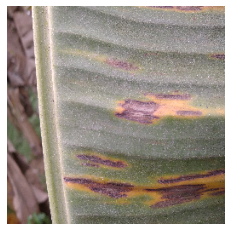

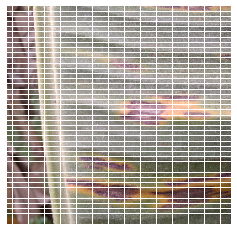

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


"""
## Implement patch creation as a layer
"""


class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


"""
Let's display patches for a sample image
"""

import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

"""
## Implement the patch encoding layer
The `PatchEncoder` layer will linearly transform a patch by projecting it into a
vector of size `projection_dim`. In addition, it adds a learnable position
embedding to the projected vector.
"""


class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        # callbacks=[checkpoint_callback],
    )

    # model.load_weights(checkpoint_filepath)
    # _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    # print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    # print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [ ]:
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/100


ResourceExhaustedError: ignored

In [ ]:
test_path='/content/drive/My Drive/Colab Notebooks/test'
test_batches=ImageDataGenerator() \
    .flow_from_directory(directory=test_path,target_size=(256,256),classes=['cordana','healthy','pestalotiopsis','sigatoka'],batch_size=10,shuffle=False)

Found 80 images belonging to 4 classes.


In [ ]:
predictions=vit_classifier.predict(x=test_batches, verbose=0)

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 99 bytes but only got 74. Skipping tag 45059
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/JpegImagePlugin.py:793: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  "Image appears to be a malformed MPO file, it will be "


In [ ]:
np.round(predictions)

array([[ 10.,   2.,  -3.,  -7.],
       [ 16.,  -3.,  -9.,  -2.],
       [  6.,  -2.,   1.,  -2.],
       [  9.,  -5.,  -5.,   4.],
       [  7.,  -5.,   3.,  -2.],
       [ 12.,   0.,  -5.,  -4.],
       [  5.,  -1.,   2.,  -3.],
       [  1.,  -6.,   3.,   2.],
       [  1.,  -4.,   1.,   3.],
       [  2.,  -4.,   2.,   3.],
       [  5.,  -0.,  -1.,  -2.],
       [  4.,  -3.,   1.,  -2.],
       [  6.,  -0.,  -1.,  -3.],
       [ -0.,  -2.,   0.,   2.],
       [ -2.,  -0.,   7.,  -2.],
       [ -3.,  -4.,  -1.,   9.],
       [  8.,  -3.,   1.,  -3.],
       [  3.,  -4.,  -1.,   3.],
       [  1.,  -1.,   1.,   0.],
       [  0.,  -1.,   2.,   0.],
       [ -4.,   5.,  -0.,   0.],
       [ -1.,   4.,  -0.,  -2.],
       [ -1.,  -2.,  -2.,   6.],
       [ -3.,   3.,   3.,  -1.],
       [ -1.,   7.,   0.,  -5.],
       [ -8.,  11.,   4.,  -4.],
       [ -6.,   8.,   1.,  -1.],
       [ -7.,   6.,   5.,  -2.],
       [ -0.,   4.,  -1.,  -1.],
       [ -8.,   8.,   2.,  -0.],
       [ -

Confusion matrix, without normalization
[[11  0  4  5]
 [ 0 18  1  1]
 [ 0  1 16  3]
 [ 0  0  1 19]]


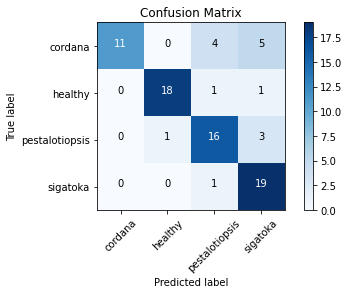

In [ ]:
cm=confusion_matrix(y_true=test_batches.classes,y_pred=np.argmax(predictions,axis=-1))
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
test_batches.class_indices
cm_plot_labels = ['cordana','healthy','pestalotiopsis','sigatoka']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')